# Power Plants in Germany

This file covers german power plants. It downloads the power plant list from the BNetzA and augments it with more information.

## Table of Contents
* [Power Plants in Germany](#Power-Plants-in-Germany)
* [License](#License)
* [Prepare the environment](#Prepare-the-environment)
* [Specify the source URLs:](#Specify-the-source-URLs:)
* [Define functions](#Define-functions)
* [Downloads](#Downloads)
	* [Download the BNetzA power plant list](#Download-the-BNetzA-power-plant-list)
	* [Download the Uba Plant list](#Download-the-Uba-Plant-list)
* [Translate contents](#Translate-contents)
	* [Columns](#Columns)
	* [Fuel types](#Fuel-types)
* [Process data](#Process-data)
	* [Set index to the BNetzA power plant ID](#Set-index-to-the-BNetzA-power-plant-ID)
	* [Delete fuels not in focus](#Delete-fuels-not-in-focus)
	* [Merge data from UBA List](#Merge-data-from-UBA-List)
	* [Add efficiency data](#Add-efficiency-data)
	* [Add geodata](#Add-geodata)
* [Validity Checks](#Validity-Checks)
	* [Visual validity check](#Visual-validity-check)
		* [Sum of capacity by fuel type](#Sum-of-capacity-by-fuel-type)
	* [Logical checks](#Logical-checks)
		* [Every power plant needs a capacity](#Every-power-plant-needs-a-capacity)
* [Write the results to file](#Write-the-results-to-file)


# License

- This notebook is published under the LICENSENAME

# Prepare the environment

In [1]:
import urllib.request
import csv
import pandas as pd
import numpy as np
import posixpath
import urllib.parse
import datetime  
import re
import os.path
import yaml  # http://pyyaml.org/, pip install pyyaml, conda install pyyaml
import json
import subprocess
%matplotlib inline

#create download and output folder if they do not exist 'downloads/'
if not os.path.exists('downloads/'): os.makedirs('downloads/')
if not os.path.exists('output/'): os.makedirs('output/')
if not os.path.exists('output/datapackage_powerplants_germany'): os.makedirs('output/datapackage_powerplants_germany')    

# Specify the source URLs:

In [2]:
# BNetzA Power plant list
url_bnetza = 'http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/Kraftwerksliste_CSV.csv?__blob=publicationFile&v=5'

# UBA Power plant list
url_uba = 'http://www.umweltbundesamt.de/sites/default/files/medien/376/dokumente/kraftwerke_in_deutschland_ab_100_megawatt_elektrischer_leistung_2015_03.xls'

# Define functions

This section defines functions used multiple times within this script

In [3]:
def downloadandcache(url):
    """This function downloads a file into a folder called 
    downloads and returns the local filepath."""
    path = urllib.parse.urlsplit(url).path
    filename = posixpath.basename(path)
    now = datetime.datetime.now()
    datestring = ""
    datestring = str(now.year)+"-"+str(now.month)+"-"+str(now.day)
    filepath = "downloads/"+datestring+"-"+filename
    
    #check if file exists, otherwise download it
    if os.path.exists(filepath) == False:
        print("Downloading file", filename)
        urllib.request.urlretrieve(url, filepath)
    else:
        print("Using local file from", filepath)
    filepath = './'+filepath
    return filepath


# Downloads

## Download the BNetzA power plant list

This section downloads the BNetzA power plant list and converts it to a pandas data frame

In [4]:
bnetza_data_filepath=(downloadandcache(url_bnetza))
#print(bnetza_data_filepath)
plantlist=pd.read_csv(bnetza_data_filepath, 
               skiprows=9,
               sep=';',  # CSV field separator, default is ','
               thousands='.',  # Thousands separator, default is ','
               decimal=',',  # Decimal separator, default is '.')  
               encoding='cp1252')
plantlist.head()

Using local file from downloads/2015-11-17-Kraftwerksliste_CSV.csv


,Kraftwerksnummer Bundesnetzagentur,Unternehmen,Kraftwerksname,PLZ (Standort Kraftwerk),Ort (Standort Kraftwerk),Straße und Hausnummer (Standort Kraftwerk),Bundesland,Blockname,Aufnahme der kommerziellen Stromerzeugung der derzeit in Betrieb befindlichen Erzeugungseinheit (Jahr),Kraftwerksstatus (in Betrieb/ vorläufig stillgelegt/ saisonale Konservierung Reservekraftwerk/ Sonderfall),Energieträger,"Spezifizierung ""Mehrere Energieträger"" und ""Sonstige Energieträger"" - Hauptbrennstoff","Spezifizierung ""Mehrere Energieträger"" - Zusatz- / Ersatzbrennstoffe",Auswertung Energieträger (Zuordnung zu einem Hauptenergieträger bei Mehreren Energieträgern),Vergütungsfähig nach EEG (ja/nein),Wärmeauskopplung (KWK) (ja/nein),Netto-Nennleistung (elektrische Wirkleistung) in MW,Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der Allgemeinen Versorgung gemäß Netzbetreiber,Netz- oder Umspannebene des Anschlusses in kV,Name Stromnetzbetreiber
0,BNA0001,NaN,NaN,52074,Aachen,NaN,Nordrhein-Westfalen,NaN,1997,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,15.0,NaN,MS,INFRAWEST GmbH
1,BNA0002,ecoJoule construct GmbH,NaN,28832,Achim,NaN,Niedersachsen,NaN,2002,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,13.3,NaN,HS/MS,EWE NETZ GmbH
2,BNA0003,Sendenhorster Windenergie GmbH & Co. KG,NaN,59229,Ahlen,NaN,Nordrhein-Westfalen,NaN,2003,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,15.0,NaN,MS,Stadtwerke Ahlen Netz GmbH
3,BNA0004,Windpark Ahlerstedt GmbH & Co. KG,NaN,21702,Ahlerstedt,NaN,Niedersachsen,NaN,1999,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,39.6,NaN,HS/MS,EWE NETZ GmbH
4,BNA0005,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,in Betrieb,Erdgas,NaN,NaN,Erdgas,Nein,Nein,37.5,Malchow,110,50 Hertz Transmission GmbH


## Download the Uba Plant list

In [5]:
uba_data_filepath=(downloadandcache(url_uba))
plantlist_uba=pd.read_excel(uba_data_filepath,
                           skiprows=9
                           )
plantlist_uba.head()

Using local file from downloads/2015-11-17-kraftwerke_in_deutschland_ab_100_megawatt_elektrischer_leistung_2015_03.xls


,Kraftwerksname / Standort,Betreiber,Bundesland,Standort-PLZ,Kraftwerksstandort,Elektrische Bruttoleistung (MW),Fernwärme-leistung (MW),Inbetriebnahme (ggf. Ertüchtigung),Anlagenart,Primärenergieträger
0,Ahrensfelde A bis D,Vattenfall Europe GmbH,BB,16356,Ahrensfelde,152.0,NaN,1990,GT,Erdgas
1,Albbruck-Dogern,Rheinkraftwerk Albbruck-Dogern AG,BW,79774,Albbruck,108.9,NaN,1933 / 2009,LWK,Wasser
2,"Altbach/Deizisau GT A-C, E",EnBW Kraftwerke AG,BW,73776,Altbach,305.0,NaN,1971-1997,GT,Erdgas
3,Altbach/Deizisau HKW 1,EnBW Kraftwerke AG,BW,73776,Altbach,476.0,280,1985 (2006),HKW,Steinkohle
4,Altbach/Deizisau HKW 2,EnBW Kraftwerke AG,BW,73776,Altbach,379.0,280,1997 (2012),HKW (DT),Steinkohle


# Translate contents

## Columns

A dictionary with the original column names to the new column names is created. This dictionary is used to translate the column names.

Original Name|Translation
-|-
Kraftwerksnummer Bundesnetzagentur|id
Unternehmen|company
Kraftwerksname|name
PLZ\n(Standort Kraftwerk)|postcode
Ort\n(Standort Kraftwerk)|city
Straße und Hausnummer (Standort Kraftwerk)|street
Bundesland|state
Blockname|block
Aufnahme der kommerziellen Stromerzeugung der derzeit in Betrieb befindlichen Erzeugungseinheit\n(Jahr)|commissioned
Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale Konservierung\nReservekraftwerk/\nSonderfall)|status
Energieträger|fuel_basis
Spezifizierung "Mehrere Energieträger" und "Sonstige Energieträger" - Hauptbrennstoff|fuel_multiple1
Spezifizierung "Mehrere Energieträger" - Zusatz- / Ersatzbrennstoffe|fuel_multiple2
Auswertung\nEnergieträger (Zuordnung zu einem Hauptenergieträger bei Mehreren Energieträgern)|fuel
Vergütungsfähig nach EEG\n(ja/nein)|eeg
Wärmeauskopplung (KWK)\n(ja/nein)|chp
Netto-Nennleistung (elektrische Wirkleistung) in MW|capacity
Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der Allgemeinen Versorgung gemäß Netzbetreiber|network_node
Netz- oder Umspannebene des Anschlusses in kV|voltage
Name Stromnetzbetreiber|network_operator

In [6]:
dict_columns = { 'Kraftwerksnummer Bundesnetzagentur':'id',
            'Unternehmen':'company',
            'Kraftwerksname':'name',
            'PLZ\n(Standort Kraftwerk)':'postcode',
            'Ort\n(Standort Kraftwerk)':'city',
            'Straße und Hausnummer (Standort Kraftwerk)':'street',
            'Bundesland':'state',
            'Blockname':'block',
            'Aufnahme der kommerziellen Stromerzeugung der derzeit in Betrieb befindlichen Erzeugungseinheit\n(Jahr)':'commissioned',
            'Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale Konservierung\nReservekraftwerk/\nSonderfall)':'status',
            'Energieträger':'fuel_basis',
            'Spezifizierung "Mehrere Energieträger" und "Sonstige Energieträger" - Hauptbrennstoff':'fuel_multiple1',
            'Spezifizierung "Mehrere Energieträger" - Zusatz- / Ersatzbrennstoffe':'fuel_multiple2',
            'Auswertung\nEnergieträger (Zuordnung zu einem Hauptenergieträger bei Mehreren Energieträgern)':'fuel',
            'Vergütungsfähig nach EEG\n(ja/nein)':'eeg',
            'Wärmeauskopplung (KWK)\n(ja/nein)':'chp',
            'Netto-Nennleistung (elektrische Wirkleistung) in MW':'capacity',
            'Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der Allgemeinen Versorgung gemäß Netzbetreiber':'network_node',
            'Netz- oder Umspannebene des Anschlusses in kV':'voltage',
            'Name Stromnetzbetreiber':'network_operator'          
          }
plantlist.rename(columns=dict_columns, inplace=True)
plantlist.columns

Index(['id', 'company', 'name', 'postcode', 'city', 'street', 'state', 'block',
       'commissioned', 'status', 'fuel_basis', 'fuel_multiple1',
       'fuel_multiple2', 'fuel', 'eeg', 'chp', 'capacity', 'network_node',
       'voltage', 'network_operator'],
      dtype='object')

## Fuel types

In [7]:
dict_fuels = {'Steinkohle':'coal',
              'Erdgas':'gas',
              'Braunkohle':'lignite',
              'Kernenergie':'uranium',
              'Pumpspeicher':'pumped_storage',
              'Biomasse':'biomass',
              'Mineralölprodukte':'oil',
              'Laufwasser':'run_of_river',
              'Sonstige Energieträger\n(nicht erneuerbar) ':'other_non_renewable',
              'Abfall':'waste',
              'Speicherwasser (ohne Pumpspeicher)':'reservoir',
              'Unbekannter Energieträger\n(nicht erneuerbar)':'unknown_non_renewable',
              'Mehrere Energieträger\n(nicht erneuerbar)':'multiple_non_renewable',
              'Deponiegas':'gas_landfill',
              'Windenergie (Onshore-Anlage)':'wind_onshore',
              'Windenergie (Offshore-Anlage)':'wind_offshore',
              'Solare Strahlungsenergie':'solar',
              'Klärgas':'gas_sewage',
              'Geothermie':'geothermal',
              'Grubengas':'gas_mine'
                        }
plantlist["fuel"].replace(dict_fuels, inplace=True)
plantlist["fuel"].unique()

array(['wind_onshore', 'gas', 'run_of_river', 'biomass', 'oil', 'coal',
       'solar', 'wind_offshore', 'pumped_storage', 'lignite', 'waste',
       'other_non_renewable', 'uranium', 'reservoir', 'gas_mine',
       'multiple_non_renewable', 'gas_landfill', 'gas_sewage',
       'geothermal', 'unknown_non_renewable'], dtype=object)

# Process data

## Set index to the BNetzA power plant ID

In [8]:
# Set Index to Kraftwerksnummer_Bundesnetzagentur
plantlist = plantlist.set_index('id')

## Delete fuels not in focus

In [9]:
# Delete unwanted fuels
plantlist = plantlist[plantlist.fuel != 'solar']
plantlist = plantlist[plantlist.fuel != 'wind_onshore']
plantlist = plantlist[plantlist.fuel != 'wind_offshore']

## Merge data from UBA List

In [10]:
# UBA List import here

## Add efficiency data

In [11]:
# Efficiencies

## Add geodata

In [12]:
# Geodata

# Validity Checks

This section tests the results in various ways to find errors

## Visual validity check

### Sum of capacity by fuel type

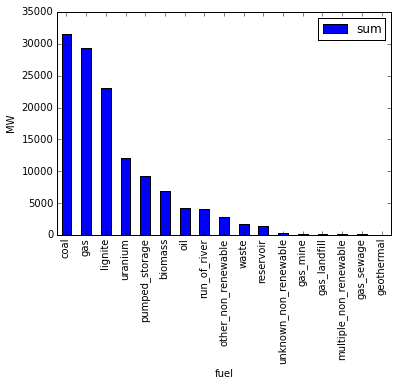

In [13]:
pivot_fuel_capacity = pd.pivot_table(
                        plantlist, 
                        values='capacity', 
                        index='fuel', 
                        aggfunc=[np.sum]
                        )
pivot_fuel_capacity.sort('sum', inplace=True, ascending=0)
#pivot_fuel_capacity
pivot_fuel_capacity_plot=pivot_fuel_capacity.plot(kind='bar')
pivot_fuel_capacity_plot.set_ylabel("MW")
pivot_fuel_capacity_plot

## Logical checks

### Every power plant needs a capacity

With the exception of placeholders.

List all entries with zero capacity:

In [14]:
list_capacity_zero = plantlist[plantlist.capacity == 0]
list_capacity_zero

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,fuel_multiple1,fuel_multiple2,fuel,eeg,chp,capacity,network_node,voltage,network_operator
id,,,,,,,,,,,,,,,,,,,
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Berlin,NaN,NaN,in Betrieb,Laufwasser,NaN,NaN,run_of_river,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Berlin,NaN,NaN,in Betrieb,Deponiegas,NaN,NaN,gas_landfill,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Saarland,NaN,NaN,in Betrieb,Deponiegas,NaN,NaN,gas_landfill,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Berlin,NaN,NaN,in Betrieb,Klärgas,NaN,NaN,gas_sewage,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Bremen,NaN,NaN,in Betrieb,Klärgas,NaN,NaN,gas_sewage,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Hamburg,NaN,NaN,in Betrieb,Klärgas,NaN,NaN,gas_sewage,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Saarland,NaN,NaN,in Betrieb,Klärgas,NaN,NaN,gas_sewage,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Baden-Württemberg,NaN,NaN,in Betrieb,Grubengas,NaN,NaN,gas_mine,Ja,NaN,0,NaN,NaN,NaN
NaN,EEG-Anlagen < 10 MW,NaN,NaN,NaN,NaN,Bayern,NaN,NaN,in Betrieb,Grubengas,NaN,NaN,gas_mine,Ja,NaN,0,NaN,NaN,NaN


# 7 Documenting the data package (meta data)

We document the data packages meta data in the specific format JSON as proposed by the Open Knowledge Foundation. See the Frictionless Data project by OKFN (http://data.okfn.org/) and the Data Package specifications (http://dataprotocols.org/data-packages/) for more details.

In order to keep the notebook more readable, we first formulate the metadata in the human-readable YAML format using a multi-line string. We then parse the string into a Python dictionary and save that to disk as a JSON file.

In [15]:
# Here we define meta data of the resulting data package.
# The meta data follows the specification at:
# http://dataprotocols.org/data-packages/

metadata = """

name: opsd-power-plants-germany
title: List of power plants in Germany.
description: This dataset contains an augmented and corrected power plant list based on the power plant list provided by the BNetzA.
version: 0.0.1
keywords: [power plants,germany]

resources:
    path: power_plants_germany.csv
    format: csv
    mediatype: text/csv
    schema:  # Schema according to: http://dataprotocols.org/json-table-schema/        
        fields:
            - name: id
              description: Power plant ID used in this list. Mostly based on the ID Provided in the BNetzA-list.
              type: string
            - name: company
              description: Company name
              type: string
            - name: name
              description: 
              type: 
              format:
            - name: postcode
              description: 
              type: 
              format:
            - name: city
              description: 
              type: 
              format:
            - name: street
              description: 
              type: 
              format:
            - name: state
              description: 
              type: 
              format:
            - name: block
              description: 
              type: 
              format:
            - name: commissioned
              description: 
              type: 
              format:
            - name: status
              description: 
              type: 
              format:
            - name: fuel_basis
              description: 
              type: 
              format:
            - name: fuel_multiple1
              description: 
              type: 
              format:
            - name: fuel_multiple2
              description: 
              type: 
              format:
            - name: fuel
              description: 
              type: 
              format:
            - name: eeg
              description: 
              type: 
              format:
            - name: chp
              description: 
              type: 
              format:
            - name: capacity
              description: 
              type: 
              format:
            - name: network_node
              description: 
              type: 
              format:
            - name: voltage
              description: 
              type: 
              format:
            - name: network_operator
              description: 
              type: 
              format:

licenses:
    - url: http://example.com/license/url/here
      name: License Name Here
      version: 1.0
      id: license-id-from-open

sources:
    - name: BNetzA Kraftwerksliste,
      web: http://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html
    - name: Umweltbundesamt Datenbank Kraftwerke in Deutschland,
      web: http://www.umweltbundesamt.de/dokument/datenbank-kraftwerke-in-deutschland

maintainers:
    - name: OPSD-Team,
      email: OPSD-Team-email,
      web: http://open-power-system-data.org/

views:
    # You can put hints here which kind of graphs or maps make sense to display your data. This makes the 
    # Data Package Viewer at http://data.okfn.org/tools/view automatically display visualazations of your data.
    # See http://data.okfn.org/doc/data-package#views for more details.    

# extend your datapackage.json with attributes that are not
# part of the data package spec
# you can add your own attributes to a datapackage.json, too

openpowersystemdata-enable-listing: True  # This is just an example we don't actually make use of yet.


"""

metadata = yaml.load(metadata)

datapackage_json = json.dumps(metadata, indent=4, separators=(',', ': '))

# Write the results to file

Determine the notebook's name.
This next block is copied from: http://stackoverflow.com/a/23619544 

In [16]:
output_path = 'output/datapackage_powerplants_germany/'
output_path2 = 'output/datapackage_powerplants_germany'

#Write the result to file
plantlist.to_csv(output_path+'power_plants_germany.csv', encoding='utf-8')

#Write as an Excel file wih both comma and point as decimal separators
plantlist.to_csv(output_path+'power_plants_germany_decimalpoint.xls', 
               sep='\t',  # CSV field separator, default is ','
               #thousands='.',  # Thousands separator, default is ','
               #decimal=',',  # Decimal separator, default is '.')  
               encoding='cp1252')
plantlist.to_csv(output_path+'power_plants_germany_decimalcomma.xls', 
               sep='\t',  # CSV field separator, default is ','
               decimal=',',  # Decimal separator, default is '.')  
               encoding='cp1252')

#Write the information of the metadata
with open(os.path.join(output_path, 'datapackage.json'), 'w') as f:
    f.write(datapackage_json)

#Set this string to this notebook's filename!    
nb_filename = 'Power_Plants_DE.ipynb'

# Save a copy of the notebook to markdown, to serve as the package README file
subprocess.call(['ipython', 'nbconvert', '--to', 'markdown', nb_filename])
path_readme = os.path.join(output_path2, 'README.md')
try:
    os.remove(path_readme)
except Exception:
    pass
os.rename(nb_filename.replace('.ipynb', '.md'), path_readme)    
    